# The Dance of Venus
In this we are going see how to determine a perfect timing for a greate Venus and Moon photo.

## Introduction
Right after sunset, we may have seen a bright star in the sky that is visible for a few hours before it vanishes below the horizon. In a few days, it will be gone and reappear in the morning hours right before sunrise. The evening star becomes the morning star.

This is not a star but the planet Venus. 
When are the Moon and Venus this close constellation? In the last couple weeks Venus was clearrly visible so how many opportunities did we have to see this constallation?

We will reduce the underlying complexity of this problem to a few simple computations that will give us an easy answer to our question.

## Let's Start
What do we need to determine the points of time where Venus and Moon are close to each other?

Well, we needd to compute the <b>phase angle</b> between the Moon and Venus as seen from our home planet Earth. The phase angle is the <b>angle that is enclosed be the two Earth -centric directional vectors that point to the Moon and to the Venus</b>.

We will compute the <b>angular distance</b> between both the objects for a certain time period. During the time period, both objects move along the Sky with changing angular distances to the Sun. We also need to compute a minimum distance between <b>Sun - Venus</b> and <b>Sun - Moon</b>. Otherwise we might compute constellations wherer all 3 objects are too close.

We will use only 2 kernel paths. de432s.bsp is required for the position computation of the celestial bodies and naif0012.tls is the kernel that contains temporal information like leap-seconds.

In [1]:
import datetime as dt
import spiceypy as sp
import numpy as np
import pandas as pd

sp.furnsh('_kernels/lsk/naif0012.tls')
sp.furnsh('_kernels/spk/de432s.bsp')

After loading the meta file with <i><b>furnsh</b></i>, we can define a time interval for our computations: the initial time is se to thte beginning of the year 2020 and the end date is 1st June 2020. The created date-time strings are converted to Ephermeris time (ET) using the SPICE function <i><b><u>utc2et</u></b></i>. The array <i>TIME_INTERVAL</i> contains all the ETs form the initial time to the end time in 3600 seconds (1 hour) steps.

In [2]:
# import the modules
# Create an initial and ending time object that is converted to a string
INIT_TIME_UTC_STR = dt.datetime(year=2020, month=1, day=1).strftime('%Y-%m-%dT%H:%M:%S')
END_TIME_UTC_STR = dt.datetime(year=2020, month=6, day=1).strftime('%Y-%m-%dT%H:%M:%S')

#Convert to Ephermeris time
INIT_TIME_ET = sp.utc2et(INIT_TIME_UTC_STR)
END_TIME_ET = sp.utc2et(END_TIME_UTC_STR)

#Set the number of seconds per hours. This value is used to compute the 
# phase angles in 1 hour steps (The ET is given in seconds)

DELTA_HOUR_IN_SECONDS = 3600.0
TIME_INTERVAL_ET = np.arange(INIT_TIME_ET, END_TIME_ET, DELTA_HOUR_IN_SECONDS)


In [3]:
len(TIME_INTERVAL_ET)

3649

To store all relavent information in a common place we use a DataFrame. The ET array is stored as well as the corresponding UTC time stamps that are being computed, by applying the spiceypy function et2datetime. We also compute the phase angle between the Venus and the Sun as seen from the Earth. For this purpose we use the SPICE function <i><b><u>phaseq</u></b></i>. This function returns the angular distance in radians between 2 objects at a certain Ephemeris time et. The documentation provides a schematic overview in the input parameters target (target body), illmn (illuminating body) and obsrve (observer body):

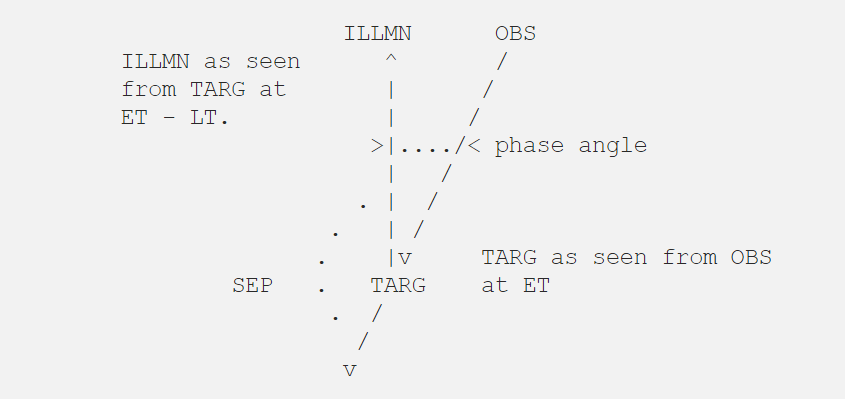

Applying the function and computational logic of <i><b><u>phaseq</u></b></i> on our problem leads to the following input parameters
1. <i>target</i>: The Earth (NAIF ID 399)
2. <i>illmn</i>: The Sun (NAIF ID 10)
3. <i>obsrvr</i>: Venus (NAIF IF 299)

Further we may notice another input parameter called <b><i>abcorr</i></b>. IN our last tutorial we computed state and directional vectors, phase angles and other parameters in rather simple steady states. Here we compute the distances in more precise way by considering the <b>light time</b> (travelling time of light) and taking the observes velocity into account. The resulting input arguement is <i><b>LT+S</b></i>

The corresponding SPICE documentation for corrections provides the following descriptions for the terms:
1. LT: correct for one-way light time (also called "planetary aberration") using a Newtonian formulation. This correction yields the state of the target at the moment it emitted photons arriving at the observer at ET.
2. LT+S: Correct for one-way light time and stellar aberration using a Newtonaian formulation. This option modifies the state obtained with the 'LT' option to account for the observer's velocity relative to the Solar System Barycenter. The result is the apparent state of the target, the position and velocity of the target as seen by the observer.

These corrections are necessary in our following tutorials, where we will also compute the positions of hazardous Asteroids where a correct timing and observation planning are crucial.

In [4]:
# All our computed parameters, position etc. shall be stored in
# a pandas df.

INNER_SOLSYS_DF = pd.DataFrame()

# Set the column ET that stores all the ETs
INNER_SOLSYS_DF.loc[:, 'ET'] = TIME_INTERVAL_ET

#The column UTC transforms all ETs back to UTC format. The 
# function sp.et2datetime is not an official part of SPICE,
# we will find there et2utc.
# However this function returns immediate datetime
INNER_SOLSYS_DF.loc[:, 'UTC'] = INNER_SOLSYS_DF['ET'].apply(lambda x: sp.et2datetime(et=x))

# Compute the phase angle of Venus and Sun as seen from Earth.

# For this computation we need the SPICE function phaseq.
# er is the ET. Based on SPICE's logic the target is the Earth (399)
# and the illumination source (illmn) is the Sun(10), the observer(obsrvr)
# is Venus with ID 299. We apply a correction that considers 
# the movement of the planets and light time (LT+S)
INNER_SOLSYS_DF.loc[:, 'EARTH_VEN2SUN_ANGLE'] = INNER_SOLSYS_DF['ET'].apply(lambda x: np.degrees(sp.phaseq(et=x,
                                                                                                          target = '399',
                                                                                                          illmn = '10',
                                                                                                          obsrvr = '299',
                                                                                                          abcorr = 'LT+S')))


In [5]:
INNER_SOLSYS_DF.head()

,ET,UTC,EARTH_VEN2SUN_ANGLE
0,6.311089e+08,2020-01-01 00:00:00+00:00,34.450582
1,6.311125e+08,2020-01-01 00:59:59.999999+00:00,34.459144
2,6.311161e+08,2020-01-01 01:59:59.999998+00:00,34.467706
3,6.311197e+08,2020-01-01 02:59:59.999996+00:00,34.476265
4,6.311233e+08,2020-01-01 03:59:59.999995+00:00,34.484824


Now we use the same to compute the phase angle between the Moon and Sun

In [6]:
# Compute the angle between the Moon and the Sun. We apply the same function
# (phaseq). The Moon NAIF ID is 301
INNER_SOLSYS_DF.loc[:, 'EARTH_MOON2SUN_ANGLE'] = INNER_SOLSYS_DF['ET'].apply(lambda x: np.degrees(sp.phaseq(et = x,
                                                                                                           target = '399',
                                                                                                           illmn = '10',
                                                                                                           obsrvr = '301',
                                                                                                           abcorr = 'LT+S')))


In [7]:
INNER_SOLSYS_DF.head()

,ET,UTC,EARTH_VEN2SUN_ANGLE,EARTH_MOON2SUN_ANGLE
0,6.311089e+08,2020-01-01 00:00:00+00:00,34.450582,66.221299
1,6.311125e+08,2020-01-01 00:59:59.999999+00:00,34.459144,66.673687
2,6.311161e+08,2020-01-01 01:59:59.999998+00:00,34.467706,67.125910
3,6.311197e+08,2020-01-01 02:59:59.999996+00:00,34.476265,67.577975
4,6.311233e+08,2020-01-01 03:59:59.999995+00:00,34.484824,68.029886


Calculate the phase angle between the moon and venus

In [8]:
# Compute finally the phase angle between the Moon and Venus
INNER_SOLSYS_DF.loc[:, 'EARTH_MOON2VEN_ANGLE'] = \
    INNER_SOLSYS_DF['ET'].apply(lambda x: \
                                    np.degrees(sp.phaseq(et=x, \
                                                               target='399', \
                                                               illmn='299', \
                                                               obsrvr='301', \
                                                               abcorr='LT+S')))


In [9]:
INNER_SOLSYS_DF.head()

,ET,UTC,EARTH_VEN2SUN_ANGLE,EARTH_MOON2SUN_ANGLE,EARTH_MOON2VEN_ANGLE
0,6.311089e+08,2020-01-01 00:00:00+00:00,34.450582,66.221299,31.815912
1,6.311125e+08,2020-01-01 00:59:59.999999+00:00,34.459144,66.673687,32.259462
2,6.311161e+08,2020-01-01 01:59:59.999998+00:00,34.467706,67.125910,32.702854
3,6.311197e+08,2020-01-01 02:59:59.999996+00:00,34.476265,67.577975,33.146093
4,6.311233e+08,2020-01-01 03:59:59.999995+00:00,34.484824,68.029886,33.589184


We can now set our requirements for a photogenic Moon — Venus constellation. A new column is added called PHOTOGENIC, where a binary value represents a “nice” (1) or “not so nice” (0) constellation. Please note that we set some artificial requirements for this computation. Tastes are different in (Astro-) Photography; so feel free to change the requirements accordingly.
Here we apply the following requirements in an if-else condition within the lambda function:
1. The angular distance between the Sun and Venus shall be larger than 30°
2. The angular distance between the Sun and the Moon shall be larger than 30°
3. The angular distance between the Moon and Venus shall be smaller than 10°

In [10]:
# Are photos of both objects "photogenic"? Let's apply a pandas filtering
# with some artificially set angular distances and create a binary tag for
# photogenic (1) and non-photogenic (0) constellations
#
# Angular distance Venus - Sun: > 30 degrees
# Angular distance Moon - Sun: > 30 degrees
# Angular distance Moon - Venus: < 10 degrees
INNER_SOLSYS_DF.loc[:, 'PHOTOGENIC'] = \
    INNER_SOLSYS_DF.apply(lambda x: 1 if (x['EARTH_VEN2SUN_ANGLE'] > 30.0) \
                                       & (x['EARTH_MOON2SUN_ANGLE'] > 30.0) \
                                       & (x['EARTH_MOON2VEN_ANGLE'] < 10.0) \
                                      else 0, axis=1)

In [16]:
len(INNER_SOLSYS_DF.loc[INNER_SOLSYS_DF['PHOTOGENIC']==1])

143

Let’s have a look at the results. We computed the phase angles in a time interval of 3649 hours (152 days). Only 143 hours (6 days) fulfil this requirement!

In [15]:
# Print the temporal results (number of computed hours, and number of
# "photogenic" hours)
print('Number of hours computed: %s (around %s days)' \
      % (len(INNER_SOLSYS_DF), round(len(INNER_SOLSYS_DF) / 24)))

print('Number of photogenic hours: %s (around %s days)' \
      % (len(INNER_SOLSYS_DF.loc[INNER_SOLSYS_DF['PHOTOGENIC'] == 1]), \
         round(len(INNER_SOLSYS_DF.loc[INNER_SOLSYS_DF['PHOTOGENIC'] == 1]) \
               / 24)))

Number of hours computed: 3649 (around 152 days)
Number of photogenic hours: 143 (around 6 days)


We can now show the results in a plot to get a feeling of the changing angular distances and the perfect time slots for our observations. For this purpose, we use matplotlib.  We set some labels for the axes, create a vertical grid for better readability and set the limits for the x axis. For the x axis we format the design and locators as little bit. Only the beginning of a month is displayed and each smaller locator represents an individual day of the month. The <b>“photogenic moments”</b> are visualized as <b>vertical blue lines</b> and are created in a for-loop, using the function <b><i><u>axvline</u></i></b>. To extract the “photogenic moments” dates, a filtering is applied using the pandas function .loc[]:

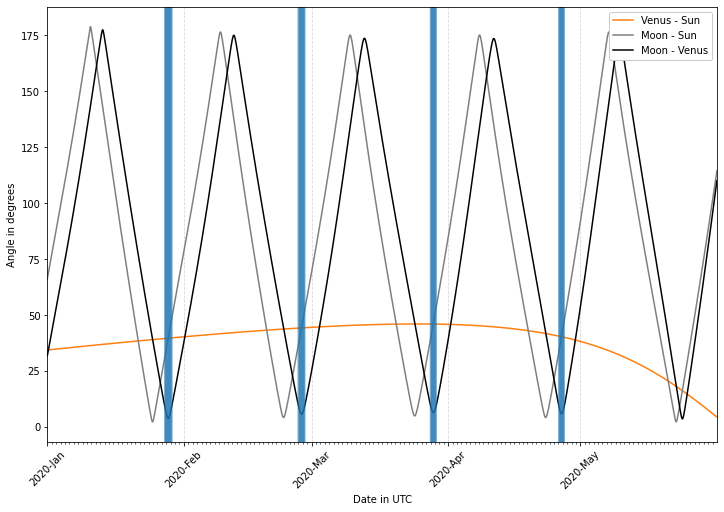

In [17]:
# Import the matplotlib library
from matplotlib import pyplot as plt
import matplotlib.dates as matpl_dates

# Set a figure
FIG, AX = plt.subplots(figsize=(12, 8))

# Plot the miscellaneous phase angles; apply different colors for the curves
# and set a legend label
AX.plot(INNER_SOLSYS_DF['UTC'], INNER_SOLSYS_DF['EARTH_VEN2SUN_ANGLE'], \
        color='tab:orange', label='Venus - Sun')

AX.plot(INNER_SOLSYS_DF['UTC'], INNER_SOLSYS_DF['EARTH_MOON2SUN_ANGLE'], \
        color='tab:gray', label='Moon - Sun')

AX.plot(INNER_SOLSYS_DF['UTC'], INNER_SOLSYS_DF['EARTH_MOON2VEN_ANGLE'], \
        color='black', label='Moon - Venus')

# Set a label for the x and y axis accordingly
AX.set_xlabel('Date in UTC')
AX.set_ylabel('Angle in degrees')

# Set limits for the x and y axis
AX.set_xlim(min(INNER_SOLSYS_DF['UTC']), max(INNER_SOLSYS_DF['UTC']))

# Set a grid
AX.grid(axis='x', linestyle='dashed', alpha=0.5)

# Set a month and day locator for the plot
AX.xaxis.set_major_locator(matpl_dates.MonthLocator())
AX.xaxis.set_minor_locator(matpl_dates.DayLocator())

# Set a format for the date-time (Year + Month name)
AX.xaxis.set_major_formatter(matpl_dates.DateFormatter('%Y-%b'))

# Iterate through the "photogenic" results and draw vertical lines where the
# "photogenic" conditions apply
for photogenic_utc in INNER_SOLSYS_DF.loc[INNER_SOLSYS_DF['PHOTOGENIC'] == 1]['UTC']:
    AX.axvline(photogenic_utc, color='tab:blue', alpha=0.2)

# Create the legend in the top right corner of the plot
AX.legend(fancybox=True, loc='upper right', framealpha=1)

# Rotate the date-times
plt.xticks(rotation=45)

# Saving the figure in high quality
plt.savefig('VENUS_SUN_MOON.png', dpi=300)

The figure below shows the resulting plot. As you can see, the angles are displayed vs. the date. One Moon orbit around the Earth is around 27 days, resulting in the fast changing pattern for the phase angles Moon — Sun and Moon — Venus, respectively. The angular distance between Venus and the Sun reached its maximum a few weeks ago and currently the distance is rapidly decreasing. End of May, the Venus will no be visible since Venus is between the Sun and Earth. This position constellation is called “lower conjunction”. In a few weeks, Venus will re-appear as the morning star.
The blue lines indicate the “photogenic moments” we have defined earlier. Each Moon revolution contains only 1 to 1.5 days of “the perfect moment”. Did you take a photo in one of these time slots?